<a href="https://colab.research.google.com/github/sallihin/hdb-resale-predictor/blob/main/training-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. Data Preparation

Data.gov.sg - Resale Flat Prices<br/>
https://data.gov.sg/dataset/resale-flat-prices


In [1]:
import pandas as pd
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error 

import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import sklearn.externals
import joblib

In [2]:
 from google.colab import drive
 drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv("/content/drive/MyDrive/MLDV/Assessment/resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv")

### 2. Exploratory Data Analysis

In [4]:
df.shape

(140168, 11)

In [5]:
df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0


In [6]:
df.dtypes

month                   object
town                    object
flat_type               object
block                   object
street_name             object
storey_range            object
floor_area_sqm         float64
flat_model              object
lease_commence_date      int64
remaining_lease         object
resale_price           float64
dtype: object

#### 2.1 Relationship between Resale Price and Block Number
Block numbers do not correlate with resale prices, and does not seem to affect the resale price. 

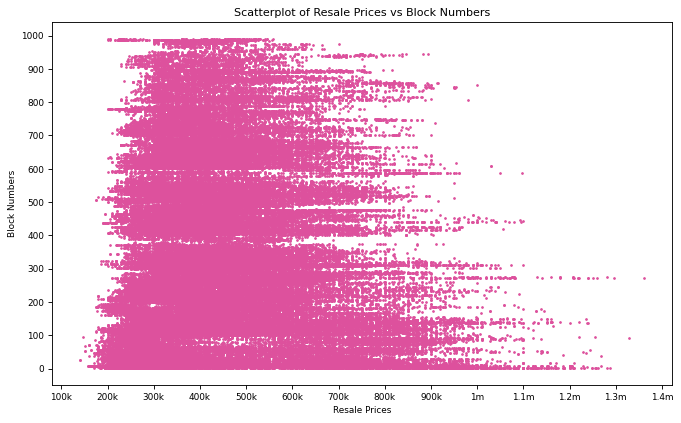

In [7]:
# Strip letters from block numbers
df['block'] = df['block'].apply(lambda x: int(re.sub("\D+", "", x)))

# Draw Plot
plt.figure(figsize=(10,6), dpi= 80)
plt.scatter(df['resale_price'], df['block'], s=2, c='#dd519d')

# Decoration
plt.xlabel("Resale Prices", fontsize=8); plt.ylabel("Block Numbers", fontsize=8)
plt.title("Scatterplot of Resale Prices vs Block Numbers", fontsize=10)
plt.xticks(ticks=[100000,200000,300000,400000,500000,600000,700000,800000,900000,1000000,1100000,1200000,1300000,1400000], 
           labels=['100k','200k','300k','400k','500k','600k','700k','800k','900k','1m','1.1m','1.2m','1.3m','1.4m'],
           fontsize=8); 
plt.yticks(ticks=[0,100,200,300,400,500,600,700,800,900,1000],
           fontsize=8)

plt.show()

#### 2.2 Relationship between Resale Price and Flat Type
Generally resale prices are higher for bigger units, although there is quite a number of outliers for 3-5 room flats due to other factors such as location and unit level. 

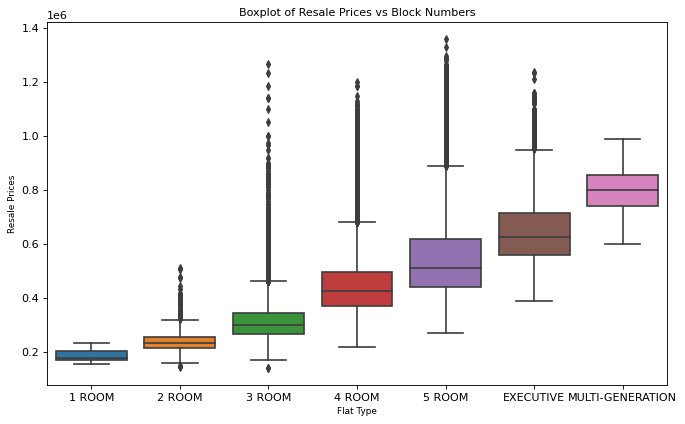

In [8]:
# Sorting 
sorted_average = df.groupby('flat_type')['resale_price'].mean().sort_values(ascending=True)

# Draw Plot
plt.figure(figsize=(10,6), dpi= 80)
sns.boxplot(x=df['flat_type'], y=df['resale_price'], order=sorted_average.index)

# Decoration
plt.xlabel("Flat Type", fontsize=8); plt.ylabel("Resale Prices", fontsize=8)
plt.title("Boxplot of Resale Prices vs Block Numbers", fontsize=10)
plt.show()

#### 2.3 Relationship between Resale Price and Town
Based on the median, houses in Bukit Timah, Queenstown and Bishan generally fetch higher prices compared to other town. 

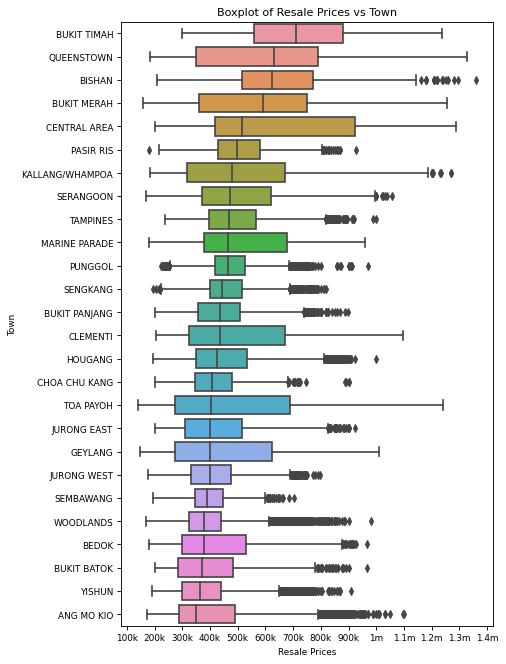

In [9]:
# Sorting 
sorted_average = df.groupby('town')['resale_price'].median().sort_values(ascending=False)

# Draw Plot
plt.figure(figsize=(6,10), dpi= 80)
sns.boxplot(x=df['resale_price'], y=df['town'], order=sorted_average.index)

# Decoration
plt.xlabel("Resale Prices", fontsize=8); plt.ylabel("Town", fontsize=8)
plt.xticks(ticks=[100000,200000,300000,400000,500000,600000,700000,800000,900000,1000000,1100000,1200000,1300000,1400000], 
           labels=['100k','200k','300k','400k','500k','600k','700k','800k','900k','1m','1.1m','1.2m','1.3m','1.4m'],
           fontsize=8); 
plt.yticks(fontsize=8)
plt.title("Boxplot of Resale Prices vs Town", fontsize=10)
plt.show()

#### 2.4 Relationship between Resale Price and Lease Commencement Date
Surprisingly there is very little correlation between the age of the flat versus the resale price. 

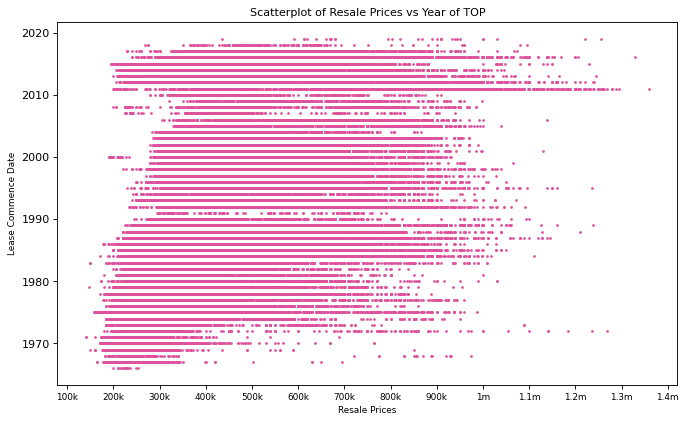

In [10]:
# Draw Plot
plt.figure(figsize=(10,6), dpi= 80)
plt.scatter(df['resale_price'], df['lease_commence_date'], s=2, c='#dd519d')

# Decoration
plt.xlabel("Resale Prices", fontsize=8); plt.ylabel("Lease Commence Date", fontsize=8)
plt.title("Scatterplot of Resale Prices vs Year of TOP", fontsize=10)
plt.xticks(ticks=[100000,200000,300000,400000,500000,600000,700000,800000,900000,1000000,1100000,1200000,1300000,1400000], 
           labels=['100k','200k','300k','400k','500k','600k','700k','800k','900k','1m','1.1m','1.2m','1.3m','1.4m'],
           fontsize=8); 
# plt.yticks(ticks=[1970, 1980, 1990, 2000, 2010, 2020],
#            fontsize=8)

plt.show()

However, when I filter the data by town and flat_type, it is clear that there is a relationship between the lease start date and price. 

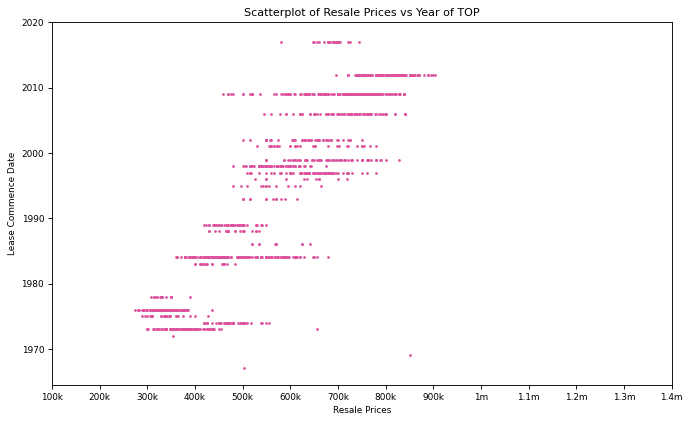

In [11]:
# Draw Plot
plt.figure(figsize=(10,6), dpi= 80)
by_town = df[(df.town == 'TOA PAYOH') & (df.flat_type == '4 ROOM')]
plt.scatter(by_town['resale_price'], by_town['lease_commence_date'], s=2, c='#dd519d')

# Decoration
plt.xlabel("Resale Prices", fontsize=8); plt.ylabel("Lease Commence Date", fontsize=8)
plt.title("Scatterplot of Resale Prices vs Year of TOP", fontsize=10)
plt.xticks(ticks=[100000,200000,300000,400000,500000,600000,700000,800000,900000,1000000,1100000,1200000,1300000,1400000], 
           labels=['100k','200k','300k','400k','500k','600k','700k','800k','900k','1m','1.1m','1.2m','1.3m','1.4m'],
           fontsize=8); 
plt.yticks(ticks=[1970, 1980, 1990, 2000, 2010, 2020],
           fontsize=8)

plt.show()

### 3. Data Preparation


#### 3.1 Feature Selection
* As HDB flats have 99 years lease, the lease_commence_date and remaining_lease are highly correlated to each other. 
* I will also remove the block numbers and street_name to reduce noise and prevent overfitting.


In [12]:
df = df.drop(columns=['remaining_lease', 'block', 'street_name'])
df.head()

,month,town,flat_type,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price
0,2017-01,ANG MO KIO,2 ROOM,10 TO 12,44.0,Improved,1979,232000.0
1,2017-01,ANG MO KIO,3 ROOM,01 TO 03,67.0,New Generation,1978,250000.0
2,2017-01,ANG MO KIO,3 ROOM,01 TO 03,67.0,New Generation,1980,262000.0
3,2017-01,ANG MO KIO,3 ROOM,04 TO 06,68.0,New Generation,1980,265000.0
4,2017-01,ANG MO KIO,3 ROOM,01 TO 03,67.0,New Generation,1980,265000.0


#### 3.2 One Hot Encoding

In [13]:
features_df = pd.get_dummies(df, columns=['town', 'flat_type', 'storey_range', 'flat_model'])

In [14]:
del features_df['resale_price']
print(features_df.columns)

Index(['month', 'floor_area_sqm', 'lease_commence_date', 'town_ANG MO KIO',
       'town_BEDOK', 'town_BISHAN', 'town_BUKIT BATOK', 'town_BUKIT MERAH',
       'town_BUKIT PANJANG', 'town_BUKIT TIMAH', 'town_CENTRAL AREA',
       'town_CHOA CHU KANG', 'town_CLEMENTI', 'town_GEYLANG', 'town_HOUGANG',
       'town_JURONG EAST', 'town_JURONG WEST', 'town_KALLANG/WHAMPOA',
       'town_MARINE PARADE', 'town_PASIR RIS', 'town_PUNGGOL',
       'town_QUEENSTOWN', 'town_SEMBAWANG', 'town_SENGKANG', 'town_SERANGOON',
       'town_TAMPINES', 'town_TOA PAYOH', 'town_WOODLANDS', 'town_YISHUN',
       'flat_type_1 ROOM', 'flat_type_2 ROOM', 'flat_type_3 ROOM',
       'flat_type_4 ROOM', 'flat_type_5 ROOM', 'flat_type_EXECUTIVE',
       'flat_type_MULTI-GENERATION', 'storey_range_01 TO 03',
       'storey_range_04 TO 06', 'storey_range_07 TO 09',
       'storey_range_10 TO 12', 'storey_range_13 TO 15',
       'storey_range_16 TO 18', 'storey_range_19 TO 21',
       'storey_range_22 TO 24', 'storey_ra

In [15]:
features_df.head()

,month,floor_area_sqm,lease_commence_date,town_ANG MO KIO,town_BEDOK,town_BISHAN,town_BUKIT BATOK,town_BUKIT MERAH,town_BUKIT PANJANG,town_BUKIT TIMAH,town_CENTRAL AREA,town_CHOA CHU KANG,town_CLEMENTI,town_GEYLANG,town_HOUGANG,town_JURONG EAST,town_JURONG WEST,town_KALLANG/WHAMPOA,town_MARINE PARADE,town_PASIR RIS,town_PUNGGOL,town_QUEENSTOWN,town_SEMBAWANG,town_SENGKANG,town_SERANGOON,town_TAMPINES,town_TOA PAYOH,town_WOODLANDS,town_YISHUN,flat_type_1 ROOM,flat_type_2 ROOM,flat_type_3 ROOM,flat_type_4 ROOM,flat_type_5 ROOM,flat_type_EXECUTIVE,flat_type_MULTI-GENERATION,storey_range_01 TO 03,storey_range_04 TO 06,storey_range_07 TO 09,storey_range_10 TO 12,storey_range_13 TO 15,storey_range_16 TO 18,storey_range_19 TO 21,storey_range_22 TO 24,storey_range_25 TO 27,storey_range_28 TO 30,storey_range_31 TO 33,storey_range_34 TO 36,storey_range_37 TO 39,storey_range_40 TO 42,storey_range_43 TO 45,storey_range_46 TO 48,storey_range_49 TO 51,flat_model_2-room,flat_model_Adjoined flat,flat_model_Apartment,flat_model_DBSS,flat_model_Improved,flat_model_Improved-Maisonette,flat_model_Maisonette,flat_model_Model A,flat_model_Model A-Maisonette,flat_model_Model A2,flat_model_Multi Generation,flat_model_New Generation,flat_model_Premium Apartment,flat_model_Premium Apartment Loft,flat_model_Premium Maisonette,flat_model_Simplified,flat_model_Standard,flat_model_Terrace,flat_model_Type S1,flat_model_Type S2
0,2017-01,44.0,1979,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2017-01,67.0,1978,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,2017-01,67.0,1980,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,2017-01,68.0,1980,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,2017-01,67.0,1980,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


#### 3.3 Data Transformation

Under the month column, I split the data into month and year of transaction and cast them as integers. 

In [16]:
features_df[['year','month']] = df.month.str.split("-",expand=True,)

In [17]:
features_df = features_df.astype({'year': 'int32', 'month': 'int32'})

In [18]:
features_df[['year', 'month']].dtypes

year     int32
month    int32
dtype: object

In [19]:
features_df[['year', 'month']].head()

,year,month
0,2017,1
1,2017,1
2,2017,1
3,2017,1
4,2017,1


### 4. Training 

In [20]:
X = features_df.values
y = df['resale_price'].values

# Split the data set in a training set (70%) and a test set (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

#### 4.1 GradientBoostingRegressor()

In [21]:
# Training to model using Grdient Boosting Regressor 
model = ensemble.GradientBoostingRegressor()

# Setting the parameter range for testing
param_grid = {
    'n_estimators': [1000, 3000],
    'max_depth': [4, 6],
    'min_samples_leaf': [9, 17],
    'learning_rate': [0.1, 0.01],
    'max_features': [1.0, 0.1],
    'loss': ['squared_error', 'huber']
}

##### 4.1.1 Hyperparameter Tuning

Abandoned GridSearch as it was taking too long and exceeded the runtime limit on Google Colab despite upgrading to a Pro+ account. 

In [22]:
# Define the grid search we want to run. Run it with four cpus in parallel.
# gs_cv = GridSearchCV(model, param_grid, n_jobs=-1, verbose=3)
# gs_cv.fit(X_train, y_train)

Used RandomSearchCV instead. Total training time was approximately 10 hours. 

In [23]:
gradient_boosting_regressor = RandomizedSearchCV(model, param_grid, n_iter=20, refit=True, verbose=3)
gradient_boosting_regressor.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END learning_rate=0.1, loss=huber, max_depth=6, max_features=1.0, min_samples_leaf=17, n_estimators=3000;, score=0.963 total time=22.7min
[CV 2/5] END learning_rate=0.1, loss=huber, max_depth=6, max_features=1.0, min_samples_leaf=17, n_estimators=3000;, score=0.964 total time=24.1min


KeyboardInterrupt: ignored

##### 4.1.2 GBR Model Results

In [ ]:
print(gradient_boosting_regressor.best_params_)

In [ ]:
# Find the error rate on the training set using the best parameters
mse = mean_absolute_error(y_train, gradient_boosting_regressor.predict(X_train))
print("Training Set Mean Absolute Error: %.4f" % mse)

In [ ]:
# Find the error rate on the test set
mse = mean_absolute_error(y_test, gradient_boosting_regressor.predict(X_test))
print("Test Set Mean Absolute Error: %.4f" % mse)

In [ ]:
# Check accuracy of model
accuracy = gradient_boosting_regressor.score(X_test, y_test)
print("Model accuracy: %.4f" % accuracy)

In [ ]:
# Find feature importance
feature_importance = gradient_boosting_regressor.feature_importances_
print(feature_importance)

#### 4.2 Random Forest Regressor

In [24]:
# Training to model using Grdient Boosting Regressor 
RandomForest = ensemble.RandomForestRegressor()

# Setting the parameter range for testing
param_grid = {
    'n_estimators': [100, 500],
    'criterion': ['squared_error', 'absolute_error', 'poisson'],
    'max_depth': [4, 6],
    'min_samples_leaf': [3, 9, 17],
    'oob_score': [True]
}

##### 4.2.1 Hyperparameter Tuning

In [25]:
random_forest = RandomizedSearchCV(RandomForest, param_grid, n_iter=20, refit=True, verbose=3)
random_forest.fit(X_train, y_train)

KeyboardInterrupt: ignored

##### 4.2.2 Random Forest Model Results

In [ ]:
print(random_forest.best_params_)

In [ ]:
# Find the error rate on the test set
mse = mean_absolute_error(y_test, random_forest.predict(X_test))
print("Test Set Mean Absolute Error: %.4f" % mse)

In [ ]:
# Check accuracy of model
accuracy = random_forest.score(X_test, y_test)
print("Model accuracy: %.4f" % accuracy)

In [ ]:
# Find feature importance
feature_importance = random_forest.feature_importances_
print(feature_importance)

In [ ]:
# Save the trained model to a file so we can use it other programs 
joblib.dump(random_search, '/content/drive/MyDrive/MLDV/Assessment/trained_hdb_resale_estimator.pkl')

### 5. Data Validation
I tested the data with some home prices on PropertyGuru to determine its accuracy in predicting today's prices. 

In [ ]:
house_to_predict = [
  1, # month you want to buy 
  132, #'floor_area_sqm 
  1983, #'lease_commence_date 

  # Select 1 Town 
  0, # ANG MO KIO
  0, # BEDOK
  0, # BISHAN 
  0, # BUKIT BATOK 
  0, # BUKIT MERAH
  0, # BUKIT PANJANG 
  0, # BUKIT TIMAH 
  0, # CENTRAL AREA
  0, # CHOA CHU KANG 
  0, # CLEMENTI 
  0, # GEYLANG 
  0, # HOUGANG
  0, # JURONG EAST 
  0, # JURONG WEST 
  0, # KALLANG/WHAMPOA
  0, # MARINE PARADE 
  0, # PASIR RIS 
  0, # PUNGGOL
  0, # QUEENSTOWN 
  0, # SEMBAWANG 
  0, # SENGKANG 
  0, # SERANGOON
  1, # TAMPINES 
  0, # TOA PAYOH 
  0, # WOODLANDS 
  0, # YISHUN

  # Select 1 Flat Type
  0, # 1 ROOM 
  0, # 2 ROOM 
  0, # 3 ROOM
  0, # 4 ROOM 
  1, # 5 ROOM 
  0, # EXECUTIVE
  0, # MULTI-GENERATION 

  # Select Floor
  0, # 01 TO 03
  1, # 04 TO 06 
  0, # 07 TO 09
  0, # 10 TO 12 
  0, # 13 TO 15
  0, # 16 TO 18 
  0, # 19 TO 21
  0, # 22 TO 24 
  0, # 25 TO 27
  0, # 28 TO 30 
  0, # 31 TO 33
  0, # 34 TO 36 
  0, # 37 TO 39
  0, # 40 TO 42 
  0, # 43 TO 45
  0, # 46 TO 48 
  0, # 49 TO 51 

  # Flat Model
  0, # 2-room
  0, # Adjoined flat 
  0, # Apartment 
  0, # DBSS
  0, # Improved 
  0, # Improved-Maisonette
  0, # Maisonette 
  1, # Model A
  0, # Model A-Maisonette 
  0, # Model A2
  0, # Multi Generation 
  0, # New Generation
  0, # Premium Apartment 
  0, # Premium Apartment Loft
  0, # Premium Maisonette 
  0, # Simplified
  0, # Standard 
  0, # Terrace 
  0, # Type S1
  0, # Type S2

  2022 # year you want to buy
]

In [this example](https://www.propertyguru.com.sg/listing/hdb-for-sale-926-tampines-street-91-23550952), the listed price was $628,000 which is within the acceptable limits. 

In [ ]:
predicted_value = random_search.predict([house_to_predict])[0]
print("This house has an estimated value of ${:,.2f}".format(predicted_value))

### 6. Conclusion

In [ ]:
fig = plt.figure(figsize=(14,7))

ax1 = plt.subplot(121)
feat_imp = pd.DataFrame({'Features': X_train.columns, 'Feature Importance': rf.feature_importances_}).sort_values('Feature Importance', ascending=False)
sns.barplot(y='Features', x='Feature Importance', data=feat_imp)
#plt.xticks(rotation=45, ha='right')
ax1.set_title('OOB Feature Importance', size=15)

ax2 = plt.subplot(122)
feat_imp = pd.DataFrame({'Features': X_train.columns, 'Feature Importance': rfr.best_estimator_.feature_importances_}).sort_values('Feature Importance', ascending=False)
sns.barplot(y='Features', x='Feature Importance', data=feat_imp)
ax2.set_title('CV Feature Importance', size=15)

plt.tight_layout(pad=0, rect=[0, 0, 0.9, 0.9])
fig.show()